In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt

In [13]:
uber = pd.read_csv("/Users/guan-hunglai/Desktop/Uber/Uber Request Data.csv")

In [14]:
uber["Request timestamp"] = pd.to_datetime(uber["Request timestamp"], dayfirst=True)
uber["Drop timestamp"] = pd.to_datetime(uber["Drop timestamp"], dayfirst=True)

In [119]:
uber['Travel Duration'] = uber["Drop timestamp"] - uber["Request timestamp"]

In [120]:
uber['Request Date'] = uber["Request timestamp"].dt.date
uber['Request Time'] = uber["Request timestamp"].dt.time
uber['Drop Date'] = uber["Drop timestamp"].dt.date
uber['Drop Time'] = uber["Drop timestamp"].dt.time
uber['Request Weekday'] = uber['Request timestamp'].apply(lambda x: dt.datetime.strftime(x, '%A'))
uber['Request Hour'] = uber['Request timestamp'].apply(lambda x: x.hour)
uber.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Date,Request Time,Drop Date,Drop Time,Request Weekday,Request Hour,Trip Completion,Travel Duration
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,2016-07-11,11:51:00,2016-07-11,13:00:00,Monday,11,True,01:09:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,2016-07-11,17:57:00,2016-07-11,18:47:00,Monday,17,True,00:50:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,2016-07-12,09:17:00,2016-07-12,09:58:00,Tuesday,9,True,00:41:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,2016-07-12,21:08:00,2016-07-12,22:03:00,Tuesday,21,True,00:55:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016-07-13,08:33:16,2016-07-13,09:25:47,Wednesday,8,True,00:52:31


### Exploratory Data Analysis

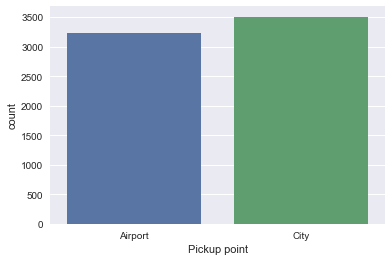

In [10]:
sns.countplot(uber['Pickup point'])

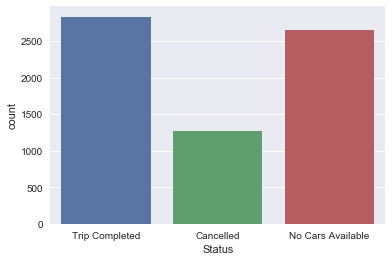

In [11]:
sns.countplot(uber['Status'])

From a frequency bar plot we can see that almost 40% of the trips are completed, whereas 16% are cancelled and 34% are not available when the customers call for a ride

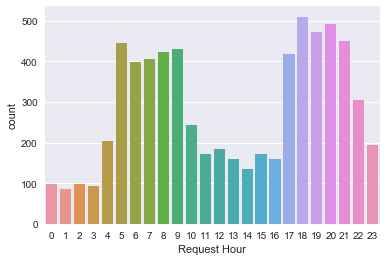

In [21]:
sns.countplot(uber['Request Hour'])

The plot shows that on average, ubers are highly requested from 5 AM to 10 AM, as well as 5 PM to 10 PM. This is a reasonable assumption as the high demand time slots corresponds to morning and afternoon commute timeslots. With that said, Uber drivers wanting to make money via surges are encouraged to work during this time.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


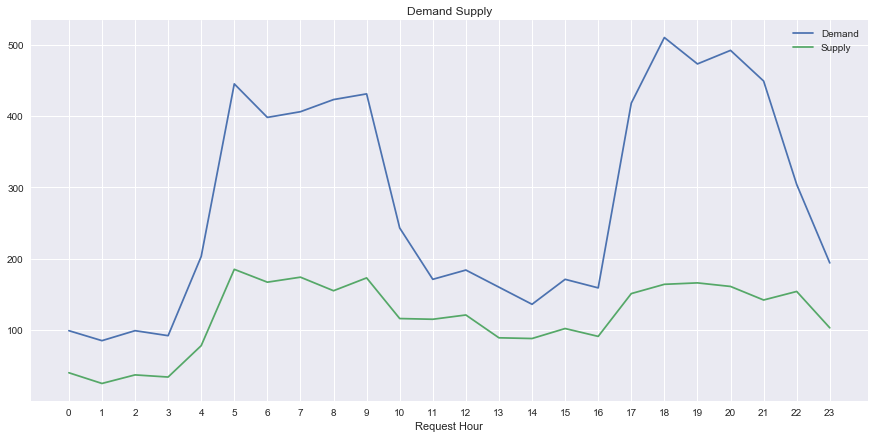

In [170]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xticks([i for i in range(0,24)])
uber.groupby(uber['Request Hour']).count()['Request id'].plot(ax=ax, label='Demand')
uber[uber['Status']=="Trip Completed"].groupby(uber[uber['Status']=="Trip Completed"]['Request Hour']).count()['Request id'].plot(ax=ax, label='Supply')

plt.grid("on")
plt.title("Demand Supply")
plt.legend()

Above is a supply and demand curve by hour by counting the cars available and number of pick ups at each hour of the day. As we can see, during peak hours, which are also number of requests at each hour, the number of supply simply doesn't match demands. In general, for this dataset, uber demands are greater than uber supplies.

### Determine Factors influencing Trip Completion Rate using Logistic Regression

In [121]:
uber["Trip Completion"] = uber["Status"] == "Trip Completed"
uber["Trip Completion"] = uber["Trip Completion"]

df = pd.DataFrame(uber, columns = ['Pickup point','Request Weekday', 'Request Hour', "Trip Completion", "Travel Duration"])
df.head()

,Pickup point,Request Weekday,Request Hour,Trip Completion,Travel Duration
0,Airport,Monday,11,True,01:09:00
1,Airport,Monday,17,True,00:50:00
2,City,Tuesday,9,True,00:41:00
3,Airport,Tuesday,21,True,00:55:00
4,City,Wednesday,8,True,00:52:31


In [122]:
uber_Weekday = pd.get_dummies(df['Request Weekday'])
uber_Pickup = pd.get_dummies(df['Pickup point'])
df2 = pd.concat([df, uber_Weekday, uber_Pickup], axis = 1)
df2["Trip Completion"] = df2["Trip Completion"].astype(int)
df2.head()

,Pickup point,Request Weekday,Request Hour,Trip Completion,Travel Duration,Friday,Monday,Thursday,Tuesday,Wednesday,Airport,City
0,Airport,Monday,11,1,01:09:00,0,1,0,0,0,1,0
1,Airport,Monday,17,1,00:50:00,0,1,0,0,0,1,0
2,City,Tuesday,9,1,00:41:00,0,0,0,1,0,0,1
3,Airport,Tuesday,21,1,00:55:00,0,0,0,1,0,1,0
4,City,Wednesday,8,1,00:52:31,0,0,0,0,1,0,1


In [102]:
uber_log = df2[['Request Hour','City', 'Airport', "Trip Completion"]]
uber_log.head()

,Request Hour,City,Airport,Trip Completion
0,11,0,1,1
1,17,0,1,1
2,9,1,0,1
3,21,0,1,1
4,8,1,0,1


In [103]:
from sklearn.model_selection import train_test_split

y = uber_log['Trip Completion']
X = uber_log.loc[:, uber_log.columns != 'Trip Completion']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42) 

In [105]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e90).fit(X_train, y_train)

print("logreg .coef_: {}".format(logreg .coef_))


print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


predicted_vals = logreg.predict(X_test)
print("logreg.predict: {}".format(predicted_vals))


logreg .coef_: [[-0.00730519 -0.06496603 -0.0946494 ]]
Training set score: 0.583
Test set score: 0.573
logreg.predict: [0 0 0 ... 0 0 0]


In [106]:
import statsmodels.api as sm

X_train_new = sm.add_constant(X_train)

model = sm.GLM(y_train, X_train_new, family=sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Trip Completion   No. Observations:                 5058
Model:                            GLM   Df Residuals:                     5055
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3434.7
Date:                Sun, 10 Mar 2019   Deviance:                       6869.4
Time:                        16:37:00   Pearson chi2:                 5.06e+03
No. Iterations:                     4   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1597      0.046     -3.502      0.000      -0.249      -0.070
Request Hour    -0.0073      0.005     -1.532      0.126      -0.017       0.002
City            -0.0650      0.031     -2.094      0.036      -0.126      -0.004
Airport         -0.0948      0.045     -2.128      0.033      -0.182      -0.007
================================================================================
"""

From our regular logistic regression result here we can see that all variables are highly significant with a very low P value, suggesting that both request hour and location contribute quite significantly to whether a driver completes a trip or not. Moreover, all the coefficients here are negative, signalling 2 important insights from this particular dataset. Firstly, the earlier an uber is being requested, or in the morning, the more likely a trip is to be completed vs a trip requesting at night. Secondly City pick-ups seem to result in higher rate of completion (greater coefficients) than airport pickups. This is a logical conclusion since airport uber pickups are usually very tricky with current taxi laws. (Anyone who has ever had to call an Uber should know the pain!)

Due to a relatively moderate accuracy rate, we decide to test the robustness of our model by adding one more variable and perform a penalized logistic regression

In [163]:
df3 = df2[['Request Hour','City', 'Airport', "Trip Completion",'Monday','Tuesday','Wednesday','Thursday','Friday',]]
df3.head()

,Request Hour,City,Airport,Trip Completion,Monday,Tuesday,Wednesday,Thursday,Friday
0,11,0,1,1,1,0,0,0,0
1,17,0,1,1,1,0,0,0,0
2,9,1,0,1,0,1,0,0,0
3,21,0,1,1,0,1,0,0,0
4,8,1,0,1,0,0,1,0,0


In [164]:
y_2 = df3['Trip Completion']
X_2 = df3.loc[:, df3.columns != 'Trip Completion']

In [165]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_2, y_2, random_state=42) 

In [166]:
#C=100, compare coefs to regular model above.
logreg2 = LogisticRegression(C=0.1).fit(X_train2, y_train2)

print("logreg .coef_: {}".format(logreg2 .coef_))


print("Training set score: {:.3f}".format(logreg2.score(X_train2, y_train2)))
print("Test set score: {:.3f}".format(logreg2.score(X_test2, y_test2)))


predicted_vals = logreg2.predict(X_test2) # y_pred includes your predictions
print("logreg.predict: {}".format(predicted_vals))

logreg .coef_: [[-0.00758328 -0.05254107 -0.08538934  0.0301068  -0.0108787   0.02638588
  -0.12129319 -0.0622512 ]]
Training set score: 0.583
Test set score: 0.573
logreg.predict: [0 0 0 ... 0 0 0]


### Random Forests

In [159]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200,
                              criterion = "gini")
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [160]:
ypred = model.predict(X_test)

In [161]:
from sklearn import metrics
print(metrics.classification_report(ypred, y_test))

             precision    recall  f1-score   support

          0       0.84      0.71      0.77      1157
          1       0.53      0.72      0.61       530

avg / total       0.74      0.71      0.72      1687



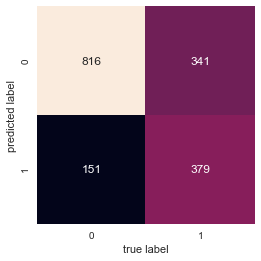

In [162]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');